In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv("C:\\Users\\ranji\\Documents\\DELL\\Data Analytics & Data Science\\24. 29th June\\Ames_house.csv")

print("Initial shape:", df.shape)
print(df.head())

Initial shape: (2930, 82)
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condi

In [4]:
# Drop ID-like columns
# -----------------------
id_cols = ['Id', 'PID']
for col in id_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)


In [5]:
# Handle missing values
# -----------------------
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

In [6]:
# -----------------------
# Dummy Encoding
# -----------------------
df = pd.get_dummies(df, drop_first=True)
print("After dummies:", df.shape)


After dummies: (2930, 262)


In [7]:

# -----------------------
# Train-Test Split
# -----------------------
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=100
)


In [8]:
# Scaling
# -----------------------
scaler = MinMaxScaler()
num_vars = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [9]:
# RFE Feature Selection
# -----------------------
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=15)  # select top 15
rfe = rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("\nSelected Features by RFE:\n", selected_features)


Selected Features by RFE:
 Index(['Lot Area', 'Overall Qual', '1st Flr SF', 'Pool Area',
       'Roof Matl_CompShg', 'Roof Matl_Roll', 'Roof Matl_Tar&Grv',
       'Roof Matl_WdShake', 'Roof Matl_WdShngl', 'Pool QC_Fa', 'Pool QC_Gd',
       'Misc Feature_Gar2', 'Misc Feature_Othr', 'Misc Feature_Shed',
       'Misc Feature_TenC'],
      dtype='object')


In [11]:
# -----------------------
# Build Model with Selected Features
# -----------------------
if len(selected_features) == 0:
    raise ValueError("No features were selected by RFE. Try increasing n_features_to_select.")

# Subset training data
X_train_rfe = X_train[selected_features].copy()

# Force numeric conversion (fix dtype issue)
X_train_rfe = X_train_rfe.apply(pd.to_numeric, errors='coerce')

# Drop any columns that became NaN after conversion
X_train_rfe = X_train_rfe.dropna(axis=1, how='any')

# Add constant
X_train_rfe = sm.add_constant(X_train_rfe, has_constant='add')

# Align y
X_train_rfe, y_train_aligned = X_train_rfe.align(y_train, axis=0)

# Convert both to numpy arrays (statsmodels likes this better)
X_train_rfe = np.asarray(X_train_rfe, dtype=np.float64)
y_train_aligned = np.asarray(y_train_aligned, dtype=np.float64)

# Fit model
lm_rfe = sm.OLS(y_train_aligned, X_train_rfe).fit()
print("\nModel Summary:\n", lm_rfe.summary())


Model Summary:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     419.0
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:40:45   Log-Likelihood:                -24550.
No. Observations:                2051   AIC:                         4.913e+04
Df Residuals:                    2035   BIC:                         4.922e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.248e+05   7.14e+04   

In [14]:
# -----------------------
# VIF Calculation
# -----------------------
X_train_vif = X_train[selected_features].copy()

# Force numeric conversion
X_train_vif = X_train_vif.apply(pd.to_numeric, errors='coerce')

# Drop any bad columns (if all values turned NaN after coercion)
X_train_vif = X_train_vif.dropna(axis=1, how='any')

# Convert to float numpy for statsmodels
X_train_vif = X_train_vif.astype(float)

vif = pd.DataFrame()
vif["Features"] = X_train_vif.columns
vif["VIF"] = [variance_inflation_factor(X_train_vif.values, i)
              for i in range(X_train_vif.shape[1])]
print("\nVIF:\n", vif)



VIF:
              Features          VIF
0            Lot Area     3.401638
1        Overall Qual    18.496097
2          1st Flr SF     8.581707
3           Pool Area     2.722268
4   Roof Matl_CompShg  1408.228669
5      Roof Matl_Roll     1.692697
6   Roof Matl_Tar&Grv    11.531295
7   Roof Matl_WdShake     4.521193
8   Roof Matl_WdShngl     4.543572
9          Pool QC_Fa     2.992163
10         Pool QC_Gd     2.409003
11  Misc Feature_Gar2     2.378549
12  Misc Feature_Othr     3.054740
13  Misc Feature_Shed  1409.843110
14  Misc Feature_TenC     2.736488


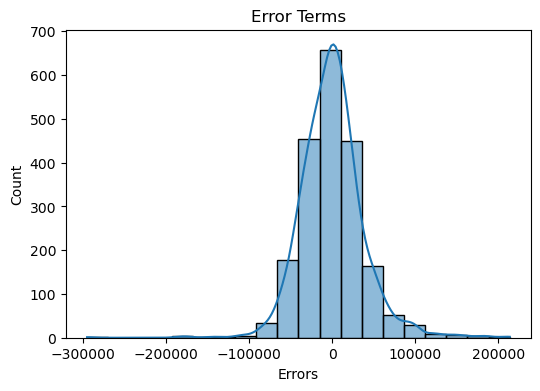

In [15]:
# Predictions on Train
# -----------------------
y_train_pred = lm_rfe.predict(X_train_rfe)

plt.figure(figsize=(6,4))
sns.histplot((y_train - y_train_pred), bins=20, kde=True)
plt.title("Error Terms")
plt.xlabel("Errors")
plt.show()


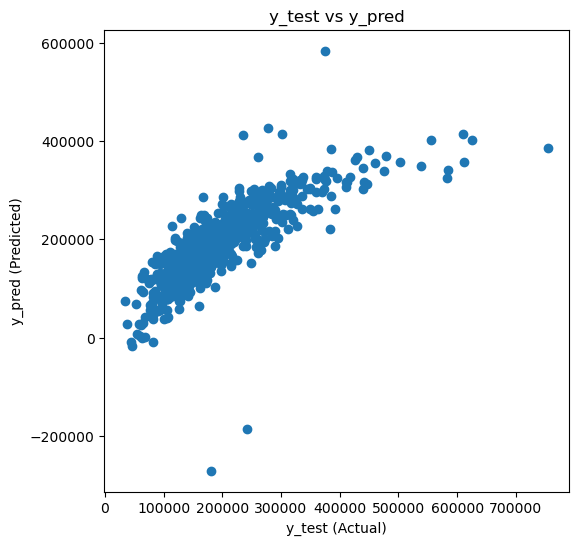

In [16]:
# Predictions on Test
# -----------------------
X_test_rfe = X_test[selected_features]
X_test_rfe = sm.add_constant(X_test_rfe, has_constant='add')

X_test_rfe, y_test_aligned = X_test_rfe.align(y_test, axis=0)

y_test_pred = lm_rfe.predict(X_test_rfe)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred)
plt.xlabel("y_test (Actual)")
plt.ylabel("y_pred (Predicted)")
plt.title("y_test vs y_pred")
plt.show()

In [17]:
# R² Scores
# -----------------------
print("\nTrain R²:", r2_score(y_train_aligned, y_train_pred))
print("Test R²:", r2_score(y_test_aligned, y_test_pred))


Train R²: 0.7554026695126924
Test R²: 0.6526736121653465
